In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

from neurolib.models.aln import ALNModel
from neurolib.utils import plotFunctions as plotFunc
from neurolib.utils import costFunctions as cost
import neurolib.dashboard.functions as functions
import neurolib.dashboard.data as data
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

#path = os.path.join(os.getcwd(), "plots")

not here


In [2]:
grid_data_file = os.path.join(os.getcwd().split('data')[0], 'bi.pickle')
print(grid_data_file)
with open(grid_data_file,'rb') as f:
    load_array= pickle.load(f)
exc = load_array[0]
inh = load_array[1]
print(len(exc))

/home/lena/Promotion/neurolib/GUI/rate/bi.pickle
147


In [3]:
aln = ALNModel()
N = aln.params.N

data.set_parameters(aln)

state_vars = aln.state_vars
init_vars = aln.init_vars

##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
##############################################################               
def setmaxmincontrol(max_c_c, min_c_c, max_c_r, min_c_r):
    import numpy as np
    
    max_cntrl = np.zeros(( 6 ))
    min_cntrl = np.zeros(( 6 ))
    
    max_cntrl[0] = max_c_c
    min_cntrl[0] = min_c_c
    max_cntrl[1] = max_c_c
    min_cntrl[1] = min_c_c
    max_cntrl[2] = max_c_r
    min_cntrl[2] = min_c_r
    max_cntrl[3] = max_c_r
    min_cntrl[3] = min_c_r
    max_cntrl[4] = max_c_r
    min_cntrl[4] = min_c_r
    max_cntrl[5] = max_c_r
    min_cntrl[5] = min_c_r
            
    return max_cntrl, min_cntrl

In [4]:
dur = 500.
t0_ = dur - 20.
t_pen = t0_/dur

In [5]:
bestControl_ = [None] * len(exc) 
bestState_ = [None] * len(exc) 
cost_ = [None] * len(exc) 
costnode_ = [None] * len(exc) 
weights_ = [None] * len(exc) 
convergence_ = [None] * len(exc) 

initVars = [None] * len(exc)
target = [None] * len(exc)
cost_uncontrolled = [None] * len(exc)
w_ = [None] * len(exc)
conv = [None] * len(exc)
conv_shift = [None] * len(exc)

In [6]:
file_ = '1_E.pickle'
folder = str(os.getcwd().split('data')[1])
print(folder)
case = str(folder[1])

/1


In [7]:
dur_pre = 10
dur_post = 10

n_pre = int(np.around(dur_pre/aln.params.dt + 1.,1))
n_post = int(np.around(dur_post/aln.params.dt + 1.,1))

tol = 1e-12
start_step = 10.
c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

if 'E' in file_:
    if case in ['1', '2']:
        c_var = [2]
    else:
        c_var = [3]
elif 'I' in file_:
    if case in ['1', '2']:
        c_var = [5]
    else:
        c_var = [4]
    
    
p_var = [0]

if case in ['1', '2']:    # low to high
    max_I = [3., -3.]
else:
    max_I = [-3., 3.]
    
if case in ['1', '3']:    # sparsity
    factor_ws = 1.
    factor_we = 0.
    cost_index = 2
else:
    factor_ws = 0.
    factor_we = 1.
    cost_index = 1
    
maxC = [5., -5., 0.2, 0.]
max_cntrl, min_cntrl = setmaxmincontrol(maxC[0], maxC[1], maxC[2], maxC[3])

In [8]:
if os.path.isfile(file_) :
    print("file found")
    
    with open(file_,'rb') as f:
        load_array = pickle.load(f)

    bestControl_ = load_array[0]
    bestState_ = load_array[1]
    cost_ = load_array[2]
    costnode_ = load_array[3]
    weights_ = load_array[4]    

file found


In [88]:
# get initial parameters and target states

i_range_ = np.arange(0, 83, 1)
i_range = []
for i in i_range_:
    if type(bestControl_[i]) == type(None):
        i_range.append(i)
        
print(i_range)

data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = 3000.
    
    control0 = aln.getZeroControl()
    control0 = functions.step_control(aln, maxI_ = max_I[0])

    aln.run(control=control0)
    
    target_rates = np.zeros((2))
    target_rates[0] = aln.rates_exc[0,-1] 
    target_rates[1] = aln.rates_inh[0,-1]

    control0 = functions.step_control(aln, maxI_ = max_I[1])
    aln.run(control=control0)

    init_state_vars = np.zeros(( len(state_vars) ))
    for j in range(len(state_vars)):
        if aln.state[state_vars[j]].size == 1:
            init_state_vars[j] = aln.state[state_vars[j]][0]
        else:
            init_state_vars[j] = aln.state[state_vars[j]][0,-1]

    initVars[i] = init_state_vars
    target[i] = [target_rates[0], target_rates[1]]

[40, 46, 47, 53, 61, 68, 71, 74, 75]
-------  40 0.5250000000000001 0.5500000000000003
-------  46 0.5250000000000001 0.5750000000000003
-------  47 0.5500000000000003 0.5750000000000003
-------  53 0.5500000000000003 0.6000000000000003
-------  61 0.5750000000000002 0.6250000000000003
-------  68 0.5750000000000002 0.6500000000000004
-------  71 0.47500000000000014 0.6750000000000004
-------  74 0.5500000000000003 0.6750000000000004
-------  75 0.5750000000000002 0.6750000000000004


In [90]:
# get uncontrolled cost

data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = dur
    
    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[i][0]
    target_[:,1,:] = target[i][1]
            
    cost.setParams(1.0, 0.0, 0.0)

    setinit(initVars[i], aln)
    control0 = aln.getZeroControl()

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = 0

    bestControl_init_, bestState_init_, cost_init_, runtime_init_, grad_init_, phi_init_, phi1_, costnode_init_ = aln.A1(
        control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
        prec_variables_ = p_var, transition_time_ = t_pen)
    
    cost_uncontrolled[i] = cost_init_[0]

-------  40 0.5250000000000001 0.5500000000000003
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
initial cost =  635238.4079859259
RUN  0 , total integrated cost =  635238.4079859259
Gradient descend method:  None
RUN  0 , total integrated cost =  635238.4079859259
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  46 0.5250000000000001 0.5750000000000003
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
initial cost =  629845.1306750294
RUN  0 , total integrated cost =  629845.1306750294
Gradient descend method:  None
RUN  0 , total integrated cost =  629845.1306750294
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  47 0.5500000000000003 0.5750000000000003
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
initial cost =  751175.9333805718
RUN  0 , total integrated cost =  751175.9333805718
Gradient descend method:  None
RUN  0 , total integrated cost =  751175.9333805718
Improved ov

In [89]:
bad = []

-------  40 0.5250000000000001 0.5500000000000003
set cost params:  1.0 0.0 1000000.0
interpolate adjoint :  True True True
initial cost =  662030.1534161234
RUN  0 , total integrated cost =  662030.1534161234
Gradient descend method:  None
RUN  1 , total integrated cost =  433967.3944023626
RUN  2 , total integrated cost =  289555.01055393583
RUN  3 , total integrated cost =  253370.19088783098
RUN  4 , total integrated cost =  198319.9688310059
RUN  5 , total integrated cost =  185780.58372435675
RUN  6 , total integrated cost =  152875.87481530555
Control only changes marginally.
RUN  6 , total integrated cost =  152875.87481530555
Improved over  6  iterations in  0.44809206699574133  seconds by  76.90801936642085  percent.


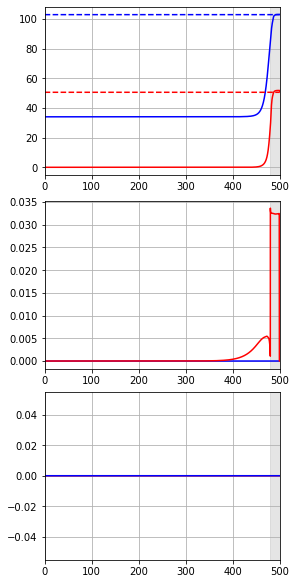

uncontrolled cost :  635238.4079859259
cost splitting :  457.0783820269093 [0.14425862 0.         0.         0.        ]
-------  46 0.5250000000000001 0.5750000000000003
set cost params:  1.0 0.0 1000000.0
interpolate adjoint :  True True True
initial cost =  680858.1058878292
RUN  0 , total integrated cost =  680858.1058878292
Gradient descend method:  None
RUN  1 , total integrated cost =  434001.9091131866
RUN  2 , total integrated cost =  307597.9521798237
RUN  3 , total integrated cost =  253925.0310273802
RUN  4 , total integrated cost =  179248.17076885168
RUN  5 , total integrated cost =  157632.86941521484
RUN  6 , total integrated cost =  31056.38616895349
RUN  7 , total integrated cost =  25730.98360772898
RUN  8 , total integrated cost =  25666.506954506196
RUN  9 , total integrated cost =  25618.95485537921
RUN  10 , total integrated cost =  25561.208567420294
RUN  10 , total integrated cost =  25561.208567420294
Improved over  10  iterations in  0.6665646170004038  secon

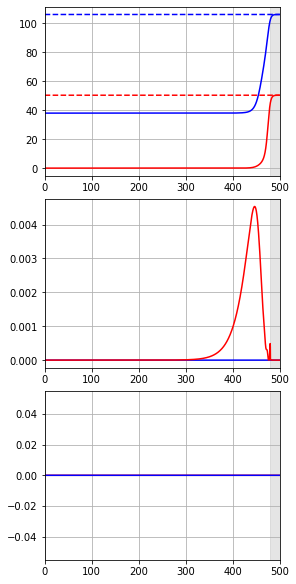

uncontrolled cost :  629845.1306750294
cost splitting :  460.77890763787195 [0.02510043 0.         0.         0.        ]
-------  47 0.5500000000000003 0.5750000000000003
set cost params:  1.0 0.0 1000000.0
interpolate adjoint :  True True True
initial cost =  666567.7041569408
RUN  0 , total integrated cost =  666567.7041569408
Gradient descend method:  None
RUN  1 , total integrated cost =  434676.26953569334
RUN  2 , total integrated cost =  228735.93938797503
Control only changes marginally.
RUN  2 , total integrated cost =  228735.93938797503
Improved over  2  iterations in  0.18082105000212323  seconds by  65.68451517205219  percent.


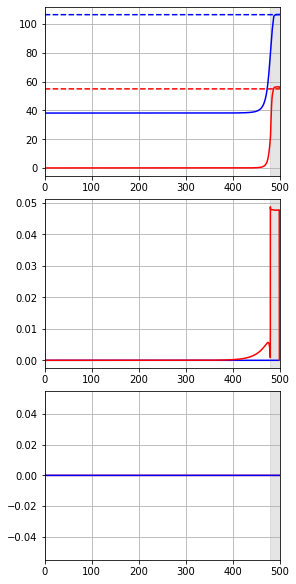

uncontrolled cost :  751175.9333805718
cost splitting :  1229.253608933328 [0.20911226 0.         0.         0.        ]
-------  53 0.5500000000000003 0.6000000000000003
set cost params:  1.0 0.0 1000000.0
interpolate adjoint :  True True True
initial cost =  685072.9493607259
RUN  0 , total integrated cost =  685072.9493607259
Gradient descend method:  None
RUN  1 , total integrated cost =  434682.3573354265
RUN  2 , total integrated cost =  309048.3984071512
Control only changes marginally.
RUN  2 , total integrated cost =  309048.3984071512
Improved over  2  iterations in  0.167767487000674  seconds by  54.88824968267409  percent.


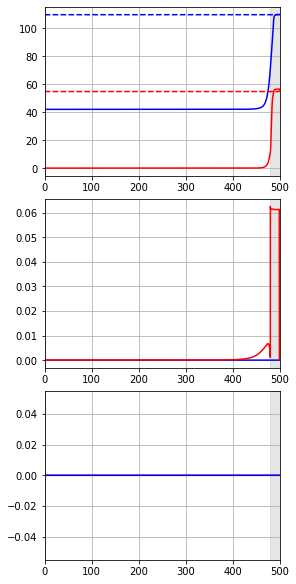

uncontrolled cost :  746144.5805987157
cost splitting :  1215.9945860251376 [0.26886429 0.         0.         0.        ]
-------  61 0.5750000000000002 0.6250000000000003
set cost params:  1.0 0.0 1000000.0
interpolate adjoint :  True True True
initial cost =  674019.4117257199
RUN  0 , total integrated cost =  674019.4117257199
Gradient descend method:  None
RUN  1 , total integrated cost =  435197.1320311325
RUN  2 , total integrated cost =  190706.59323595316
Control only changes marginally.
RUN  2 , total integrated cost =  190706.59323595316
Improved over  2  iterations in  0.16588469900307246  seconds by  71.70606811639458  percent.


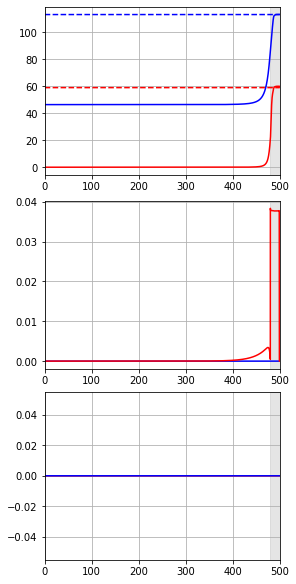

uncontrolled cost :  866710.8536802017
cost splitting :  953.6869095883259 [0.16525184 0.         0.         0.        ]
-------  68 0.5750000000000002 0.6500000000000004
set cost params:  1.0 0.0 1000000.0
interpolate adjoint :  True True True
initial cost =  690391.3134434847
RUN  0 , total integrated cost =  690391.3134434847
Gradient descend method:  None
RUN  1 , total integrated cost =  435190.3266498846
RUN  2 , total integrated cost =  236060.72720686285
Control only changes marginally.
RUN  2 , total integrated cost =  236060.72720686285
Improved over  2  iterations in  0.1699124440056039  seconds by  65.8076915786417  percent.


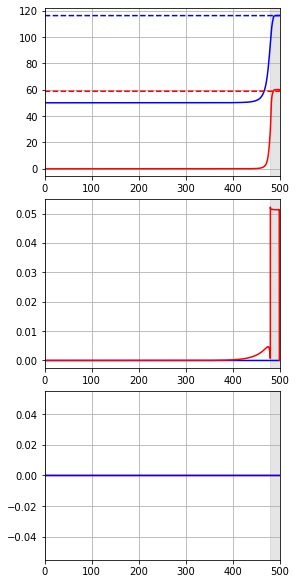

uncontrolled cost :  862467.9253654084
cost splitting :  963.0141493650157 [0.22500206 0.         0.         0.        ]
-------  71 0.47500000000000014 0.6750000000000004
set cost params:  1.0 0.0 1000000.0
interpolate adjoint :  True True True
initial cost =  698926.0242718477
RUN  0 , total integrated cost =  698926.0242718477
Gradient descend method:  None
RUN  1 , total integrated cost =  431718.21865973197
RUN  2 , total integrated cost =  384005.6229650372
RUN  3 , total integrated cost =  384005.5969291668
Control only changes marginally.
RUN  3 , total integrated cost =  384005.5969291668
Improved over  3  iterations in  0.2699944650012185  seconds by  45.05776239635232  percent.


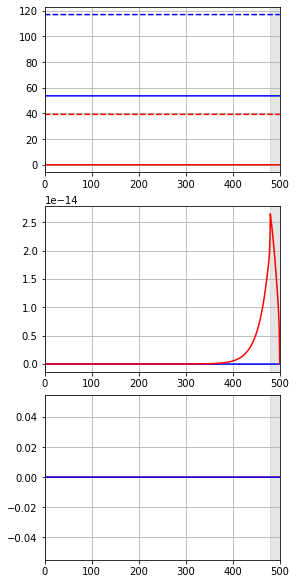

uncontrolled cost :  384005.59692905797
cost splitting :  384005.5969290578 [1.08838355e-13 0.00000000e+00 0.00000000e+00 0.00000000e+00]
-------  74 0.5500000000000003 0.6750000000000004
set cost params:  1.0 0.0 1000000.0
interpolate adjoint :  True True True
initial cost =  725663.8205197075
RUN  0 , total integrated cost =  725663.8205197075
Gradient descend method:  None
RUN  1 , total integrated cost =  434726.5938077301
RUN  2 , total integrated cost =  321506.1522902829
Control only changes marginally.
RUN  2 , total integrated cost =  321506.1522902829
Improved over  2  iterations in  0.18006195199996  seconds by  55.69489022340594  percent.


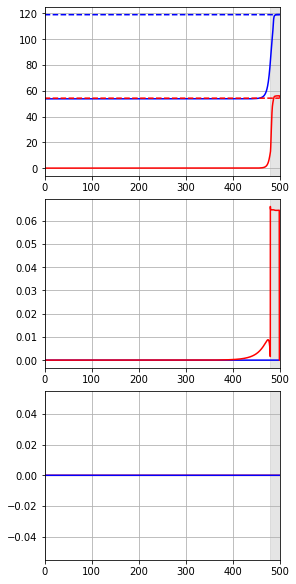

uncontrolled cost :  732509.8149166821
cost splitting :  1225.2636061661663 [0.28384811 0.         0.         0.        ]
-------  75 0.5750000000000002 0.6750000000000004
set cost params:  1.0 0.0 1000000.0
interpolate adjoint :  True True True
initial cost =  704013.5881302985
RUN  0 , total integrated cost =  704013.5881302985
Gradient descend method:  None
RUN  1 , total integrated cost =  435141.2864842731
RUN  2 , total integrated cost =  288251.68418131355
Control only changes marginally.
RUN  2 , total integrated cost =  288251.68418131355
Improved over  2  iterations in  0.17822814799728803  seconds by  59.0559487712666  percent.


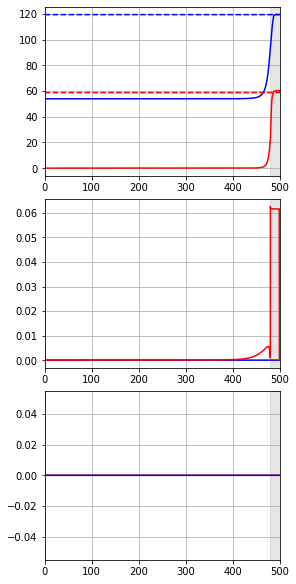

uncontrolled cost :  858276.8196420075
cost splitting :  964.9785557665969 [0.26975238 0.         0.         0.        ]


In [91]:
cgv = None
j = 0
c_var = [2]

wp = 1.

for i in i_range:

    print("------- ", i, exc[i], inh[i])
    
    if i in bad:
        continue
        
    if type(bestControl_[i]) != type(None):
        continue
        
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
        
    found_exponent = False
    found_digit_0 = False
    found_digit_1 = False
    exponent = 6
    sig_digit = [1., 0.]
    
    while not found_digit_1:
        
        w_[i] = sig_digit[0] * 10**exponent + sig_digit[1] * 10**(exponent-1.)
    
        aln.params.duration = dur
        setinit(initVars[i], aln)

        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        control0 = aln.getZeroControl()
        control0[0,2,4800:4990] = 0.1
        cost.setParams(wp, w_[i] * factor_we, w_[i] * factor_ws)
        max_it = int(10)
        if found_digit_0:
            max_it = int(20)

        bestControl_[i], bestState_[i], cost_[i], runtime_, grad_, phi_, phi1_, costnode_[i] = aln.A1(
            control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
            prec_variables_ = p_var, transition_time_ = t_pen)
        
        if found_exponent == False and cost_[i][-1] == 0.:
            exponent -= 1
            #continue
        elif found_exponent == False and found_digit_0 == False:
            found_exponent = True
            sig_digit[0] = 9.
        elif found_exponent == True and found_digit_0 == False and cost_[i][-1] == 0.:
            sig_digit[0] -= 1.
        elif found_exponent == True and found_digit_0 == False:
            found_digit_0 = True
            sig_digit[1] = 9.
        elif found_exponent == True and found_digit_0 == True and found_digit_1 == False and cost_[i][-1] == 0.:
            sig_digit[1] -= 1.
        elif found_exponent == True and found_digit_0 == True and found_digit_1 == False:
            print("sparsity weight = ", w_[i])
            
        if True:
            plot_time_array = np.arange(0.,round(dur+aln.params.dt,1),aln.params.dt)
            target_ = aln.getZeroTarget()
            target_[:,0,:] = target[i][0]
            target_[:,1,:] = target[i][1]

            fig, ax = plt.subplots(3,1, constrained_layout=True, figsize = (4,8) )

            ax[0].plot(plot_time_array, bestState_[i][0,0,n_pre-1:-n_post+1], color= 'red')
            ax[0].plot(plot_time_array, bestState_[i][0,1,n_pre-1:-n_post+1], color= 'blue')
            ax[0].plot(plot_time_array, target_[0,0,n_pre-1:-n_post+1], linestyle = '--', color='red')
            ax[0].plot(plot_time_array, target_[0,1,n_pre-1:-n_post+1], linestyle = '--', color='blue')

            ax[1].plot(plot_time_array, bestControl_[i][0,3,n_pre-1:-n_post+1], color = 'blue')
            ax[1].plot(plot_time_array, bestControl_[i][0,2,n_pre-1:-n_post+1], color = 'red')

            ax[2].plot(plot_time_array, bestControl_[i][0,4,n_pre-1:-n_post+1], color = 'red')
            ax[2].plot(plot_time_array, bestControl_[i][0,5,n_pre-1:-n_post+1], color = 'blue')

            for k in range(3):
                ax[k].set_xlim(0.,dur)
                ax[k].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
            plt.show()
              
            #if np.amax(np.abs(bestControl_[i])) > 1e-4:
            #    with open(file_,'wb') as f:
            #        pickle.dump([bestControl_, bestState_, cost_, costnode_, weights_], f)

            print('uncontrolled cost : ', cost_uncontrolled[i])
            print('cost splitting : ', costnode_[i][0][0][0], costnode_[i][cost_index][0][2:])    

            break    
            

In [35]:
if os.path.isfile(file_) :
    print("file found")
    
    with open(file_,'rb') as f:
        load_array = pickle.load(f)

    bestControl_ = load_array[0]
    bestState_ = load_array[1]
    cost_ = load_array[2]
    costnode_ = load_array[3]
    weights_ = load_array[4]    

file found


In [92]:
with open(file_,'wb') as f:
    pickle.dump([bestControl_, bestState_, cost_, costnode_, weights_], f)

-------  40 0.5250000000000001 0.5500000000000003
--------------- k  0
1000000.0
set cost params:  1.0 0.0 1000000.0
interpolate adjoint :  True True True
initial cost =  18508.668054662507
RUN  0 , total integrated cost =  18508.668054662507
Gradient descend method:  None
RUN  1 , total integrated cost =  18126.347913736656
RUN  2 , total integrated cost =  18126.29512768578
RUN  3 , total integrated cost =  18126.281483770614
RUN  4 , total integrated cost =  18126.260174253966
RUN  5 , total integrated cost =  18126.25230366053
RUN  6 , total integrated cost =  18126.229978736654
RUN  7 , total integrated cost =  18126.21419446644
RUN  8 , total integrated cost =  18124.47522101854
RUN  9 , total integrated cost =  18122.911028460854
Control only changes marginally.
RUN  9 , total integrated cost =  18122.911028460854
Improved over  9  iterations in  3.1978222070029005  seconds by  2.084196577854101  percent.
cost splitting :  10.171171674522851 [0.0181066 0.        0.        0.    

RUN  1 , total integrated cost =  161605.78566313107
Control only changes marginally.
RUN  1 , total integrated cost =  161605.78566313107
Improved over  1  iterations in  0.44209965900518  seconds by  0.004320084236951516  percent.
cost splitting :  33.43802728592167 [0.02170713 0.         0.         0.        ]
--------------- k  34
set cost params:  1.0 0.0 10524774.00189511
interpolate adjoint :  True True True
initial cost =  228518.63045752386
RUN  0 , total integrated cost =  228518.63045752386
Gradient descend method:  None
RUN  1 , total integrated cost =  228514.792432601
Control only changes marginally.
RUN  1 , total integrated cost =  228514.792432601
Improved over  1  iterations in  0.4778955540023162  seconds by  0.0016795238599058848  percent.
cost splitting :  55.94622549420677 [0.02170475 0.         0.         0.        ]
--------------- k  45
set cost params:  1.0 0.0 13607288.925730864
interpolate adjoint :  True True True
initial cost =  295419.9943424469
RUN  0 , 

RUN  1 , total integrated cost =  507121.4333099308
Control only changes marginally.
RUN  1 , total integrated cost =  507121.4333099308
Improved over  1  iterations in  0.5384059530042578  seconds by  0.0015249001242096938  percent.
cost splitting :  483.8635916410449 [0.01096501 0.         0.         0.        ]
--------------- k  78
set cost params:  1.0 0.0 53620742.80247317
interpolate adjoint :  True True True
initial cost =  588522.688070485
RUN  0 , total integrated cost =  588522.688070485
Gradient descend method:  None
RUN  1 , total integrated cost =  588515.6677047327
Control only changes marginally.
RUN  1 , total integrated cost =  588515.6677047327
Improved over  1  iterations in  0.6413151570013724  seconds by  0.0011928793731499354  percent.
cost splitting :  570.570876480011 [0.01096315 0.         0.         0.        ]
--------------- k  89
set cost params:  1.0 0.0 61044921.65295715
interpolate adjoint :  True True True
initial cost =  669908.0645851208
RUN  0 , tot

RUN  1 , total integrated cost =  5835.764561858314
RUN  2 , total integrated cost =  5835.735775551183
RUN  3 , total integrated cost =  5835.61234072695
RUN  4 , total integrated cost =  5835.460732805311
Control only changes marginally.
RUN  4 , total integrated cost =  5835.460732805311
Improved over  4  iterations in  2.1142870799958473  seconds by  4.941583862743329  percent.
cost splitting :  1.7652980231694735 [0.00583295 0.         0.         0.        ]
--------------- k  1
set cost params:  1.0 0.0 2475885.2892453605
interpolate adjoint :  True True True
initial cost =  14444.222141622848
RUN  0 , total integrated cost =  14444.222141622848
Gradient descend method:  None
RUN  1 , total integrated cost =  14442.37884023792
Control only changes marginally.
RUN  1 , total integrated cost =  14442.37884023792
Improved over  1  iterations in  0.5610948920002556  seconds by  0.012761513682463033  percent.
cost splitting :  2.5132323804571577 [0.00583078 0.         0.         0.   

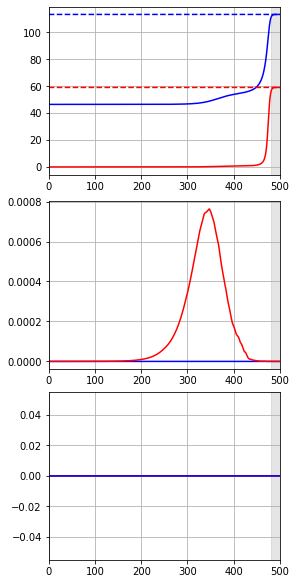

-------  68 0.5750000000000002 0.6500000000000004
--------------- k  0
1000000.0
set cost params:  1.0 0.0 1000000.0
interpolate adjoint :  True True True
initial cost =  8403.240261564912
RUN  0 , total integrated cost =  8403.240261564912
Gradient descend method:  None
RUN  1 , total integrated cost =  8078.49213685897
RUN  2 , total integrated cost =  8078.483211669613
Control only changes marginally.
RUN  2 , total integrated cost =  8078.483211669613
Improved over  2  iterations in  1.1926775059982901  seconds by  3.8646645792181573  percent.
cost splitting :  4.220678416733783 [0.00807399 0.         0.         0.        ]
--------------- k  1
set cost params:  1.0 0.0 2058200.5244938983
interpolate adjoint :  True True True
initial cost =  16622.380389487735
RUN  0 , total integrated cost =  16622.380389487735
Gradient descend method:  None
RUN  1 , total integrated cost =  16620.665215947458
Control only changes marginally.
RUN  1 , total integrated cost =  16620.665215947458
Im

RUN  1 , total integrated cost =  106578.76586606109
Control only changes marginally.
RUN  1 , total integrated cost =  106578.76586606109
Improved over  1  iterations in  0.5918843820036273  seconds by  0.0  percent.
cost splitting :  0.28800035902317633 [0.02122424 0.         0.         0.        ]
--------------- k  23
set cost params:  1.0 0.0 8707959.625359759
interpolate adjoint :  True True True
initial cost =  184820.14699738874
RUN  0 , total integrated cost =  184820.14699738874
Gradient descend method:  None
RUN  1 , total integrated cost =  184819.59172756062
Control only changes marginally.
RUN  1 , total integrated cost =  184819.59172756062
Improved over  1  iterations in  0.6260881449998124  seconds by  0.00030043793231016025  percent.
cost splitting :  0.28800035902317633 [0.0212241 0.        0.        0.       ]
--------------- k  34
set cost params:  1.0 0.0 12394455.939551555
interpolate adjoint :  True True True
initial cost =  263062.1496185576
RUN  0 , total inte

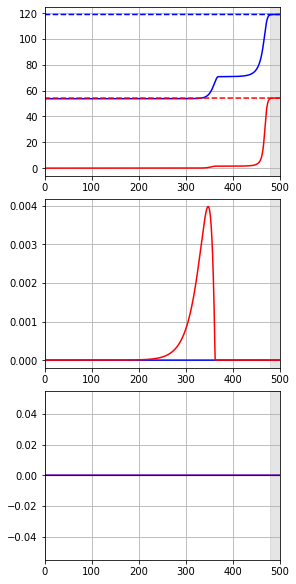

-------  75 0.5750000000000002 0.6750000000000004
--------------- k  0
1000000.0
set cost params:  1.0 0.0 1000000.0
interpolate adjoint :  True True True
initial cost =  10335.011528609866
RUN  0 , total integrated cost =  10335.011528609866
Gradient descend method:  None
RUN  1 , total integrated cost =  9970.613624157142
RUN  2 , total integrated cost =  9970.51874671256
RUN  3 , total integrated cost =  9970.508196394245
RUN  4 , total integrated cost =  9970.491450610405
Control only changes marginally.
RUN  4 , total integrated cost =  9970.491450610405
Improved over  4  iterations in  2.3622301279974636  seconds by  3.5270408454831426  percent.
cost splitting :  5.16251970857912 [0.00996491 0.         0.         0.        ]
--------------- k  1
set cost params:  1.0 0.0 1851293.9133018972
interpolate adjoint :  True True True
initial cost =  18453.558919028055
RUN  0 , total integrated cost =  18453.558919028055
Gradient descend method:  None
RUN  1 , total integrated cost =  18

RUN  1 , total integrated cost =  858296.664382196
RUN  2 , total integrated cost =  858295.4421427435
RUN  3 , total integrated cost =  858294.5005460951
RUN  4 , total integrated cost =  858294.1889401705
RUN  5 , total integrated cost =  858293.6437380213
Control only changes marginally.
RUN  5 , total integrated cost =  858293.6437380213
Improved over  5  iterations in  2.7513679260009667  seconds by  0.0003637795915949482  percent.
cost splitting :  366.3357640712644 [0.00994386 0.         0.         0.        ]
--------------- k  115
set cost params:  1.0 0.0 86275381.2379308
interpolate adjoint :  True True True
initial cost =  858295.8282148837
RUN  0 , total integrated cost =  858295.8282148837
Gradient descend method:  None
RUN  1 , total integrated cost =  858295.7386307367
RUN  2 , total integrated cost =  858294.5222609615
RUN  3 , total integrated cost =  858293.6049689808
RUN  4 , total integrated cost =  858293.2424514423
RUN  5 , total integrated cost =  858292.6361132

RUN  5 , total integrated cost =  858300.6346517861
Control only changes marginally.
RUN  5 , total integrated cost =  858300.6346517861
Improved over  5  iterations in  2.921377243997995  seconds by  0.0004686484820979331  percent.
cost splitting :  345.2967860560845 [0.00994348 0.         0.         0.        ]
--------------- k  126
set cost params:  1.0 0.0 86280785.43222736
interpolate adjoint :  True True True
initial cost =  858314.8081360894
RUN  0 , total integrated cost =  858314.8081360894
Gradient descend method:  None
RUN  1 , total integrated cost =  858314.6952483039
RUN  2 , total integrated cost =  858313.848350842
RUN  3 , total integrated cost =  858313.2272761913
RUN  4 , total integrated cost =  858312.8837985421
RUN  5 , total integrated cost =  858312.2756554516
Control only changes marginally.
RUN  5 , total integrated cost =  858312.2756554516
Improved over  5  iterations in  2.994083406003483  seconds by  0.0002950526559430955  percent.
cost splitting :  361.8

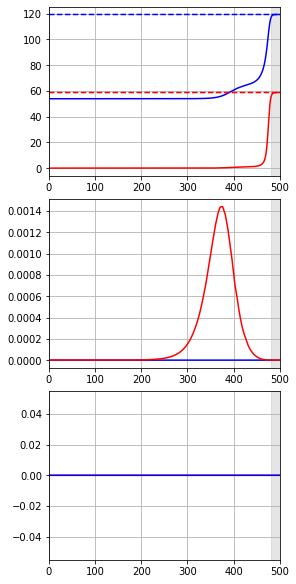

In [94]:
tol = 1e-8
conv = [None] * len(exc)
c_var = [2,3,4,5]

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    k = 0
    if i in bad:
        continue
        
    while not conv[i]:
        print('--------------- k ', k)
        max_it = min(1000, int(100*k))
        
        if k == 0:
            max_it = 100
            weight_ = w_[i]
            print(weight_)
            if weight_ < 100:
                bad.append(i)
                bestControl_[i] = None
                conv[i] = True
                continue
        else:
            weight_ = ( cost_uncontrolled[i] - costnode_[i][0][0][0] ) / sum( costnode_[i][cost_index][0][:] )
            if k < 100:
                weight_ = w_[i] + 0.01 *k * (weight_ - w_[i])
            
        aln.params.duration = dur
        cost.setParams(1., weight_ * factor_we, weight_ * factor_ws)
        weights_[i] = cost.getParams()

        setinit(initVars[i], aln)

        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        control0 = aln.getZeroControl()
        control0 = bestControl_[i][:,:,n_pre-1:-n_post+1]

        bestControl_[i], bestState_[i], cost_[i], runtime_, grad_, phi_, phi1_, costnode_[i] = aln.A1(
            control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
            prec_variables_ = p_var, transition_time_ = t_pen)
        
        if cost_[i][2] == 0.:
            if k > 100:
                conv[i] = True
            else: 
                k += 10

        #print('uncontrolled cost : ', cost_uncontrolled[i])
        print('cost splitting : ', costnode_[i][0][0][0], costnode_[i][cost_index][0][2:])

        if conv[i]:
            plot_time_array = np.arange(0.,round(dur+aln.params.dt,1),aln.params.dt)
            target_ = aln.getZeroTarget()
            target_[:,0,:] = target[i][0]
            target_[:,1,:] = target[i][1]

            fig, ax = plt.subplots(3,1, constrained_layout=True, figsize = (4,8) )

            ax[0].plot(plot_time_array, bestState_[i][0,0,n_pre-1:-n_post+1], color= 'red')
            ax[0].plot(plot_time_array, bestState_[i][0,1,n_pre-1:-n_post+1], color= 'blue')
            ax[0].plot(plot_time_array, target_[0,0,n_pre-1:-n_post+1], linestyle = '--', color='red')
            ax[0].plot(plot_time_array, target_[0,1,n_pre-1:-n_post+1], linestyle = '--', color='blue')

            ax[1].plot(plot_time_array, bestControl_[i][0,3,n_pre-1:-n_post+1], color = 'blue')
            ax[1].plot(plot_time_array, bestControl_[i][0,2,n_pre-1:-n_post+1], color = 'red')

            ax[2].plot(plot_time_array, bestControl_[i][0,4,n_pre-1:-n_post+1], color = 'red')
            ax[2].plot(plot_time_array, bestControl_[i][0,5,n_pre-1:-n_post+1], color = 'blue')

            for l in range(3):
                ax[l].set_xlim(0.,dur)
                ax[l].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
            plt.show()

        if np.abs(target_[0,0,0] - bestState_[i][0,0,-1]) < 3.:
            with open(file_,'wb') as f:
                pickle.dump([bestControl_, bestState_, cost_, costnode_, weights_], f)
        else:
            print("converged to zero, reload and break")
            if os.path.isfile(file_) :
                print("file found")

                with open(file_,'rb') as f:
                    load_array = pickle.load(f)

                bestControl_ = load_array[0]
                bestState_ = load_array[1]
                cost_ = load_array[2]
                costnode_ = load_array[3]
                weights_ = load_array[4]   
            break
        
        k += 1

ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


-------  40 0.5250000000000001 0.5500000000000003
init ind =  2140
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  0.018062622301699235
RUN  0 , total integrated cost =  0.018062622301699235
Gradient descend method:  None
RUN  0 , total integrated cost =  0.018062622301699235
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5104344949752526 1.5104344768994618
Problem in initial value trasfer pre:  tau_exc 20.72012142522508 20.720121561789153
uncontrolled cost :  635238.4079859259
cost splitting :  1.8088547589396454e-24 [0. 0.]


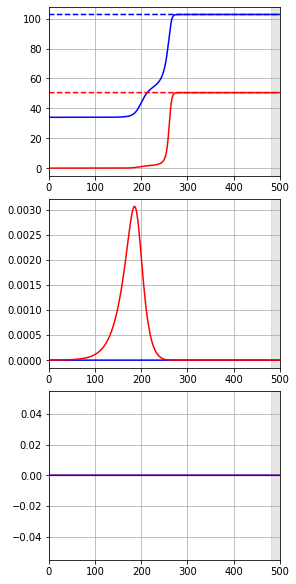

ERROR:root:Problem in initial value trasfer pre


-------  46 0.5250000000000001 0.5750000000000003
init ind =  2026
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  0.021698915480438192
RUN  0 , total integrated cost =  0.021698915480438192
Gradient descend method:  None
RUN  0 , total integrated cost =  0.021698915480438192
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
Problem in initial value trasfer pre:  tau_exc 20.968375036952285 20.968375085364308
uncontrolled cost :  629845.1306750294
cost splitting :  1.0174808019035437e-24 [0. 0.]


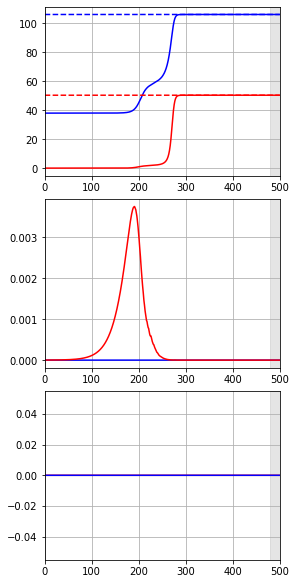

ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


-------  47 0.5500000000000003 0.5750000000000003
init ind =  2087
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  0.010961589641931805
RUN  0 , total integrated cost =  0.010961589641931805
Gradient descend method:  None
RUN  0 , total integrated cost =  0.010961589641931805
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5089984866711772 1.5089984157716678
Problem in initial value trasfer pre:  tau_exc 20.22212870481313 20.222129325205636
uncontrolled cost :  751175.9333805718
cost splitting :  3.1403728453813175e-25 [0. 0.]


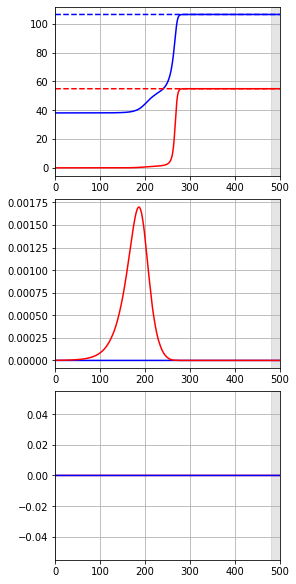

ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


-------  53 0.5500000000000003 0.6000000000000003
init ind =  2039
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  0.013830957396881212
RUN  0 , total integrated cost =  0.013830957396881212
Gradient descend method:  None
RUN  0 , total integrated cost =  0.013830957396881212
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5067436824094098 1.5067436485188608
Problem in initial value trasfer pre:  tau_exc 20.53175493676201 20.531755211735987
uncontrolled cost :  746144.5805987157
cost splitting :  3.1403728453813175e-25 [0. 0.]


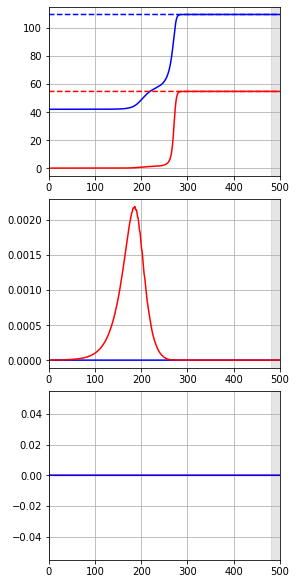

ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


-------  61 0.5750000000000002 0.6250000000000003
init ind =  1414
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  0.0058219219855041
RUN  0 , total integrated cost =  0.0058219219855041
Gradient descend method:  None
RUN  0 , total integrated cost =  0.0058219219855041
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5080478142378089 1.5080476343301121
Problem in initial value trasfer pre:  tau_exc 19.698150393027262 19.698152165362128
uncontrolled cost :  866710.8536802017
cost splitting :  2.0098386210440446e-25 [0. 0.]


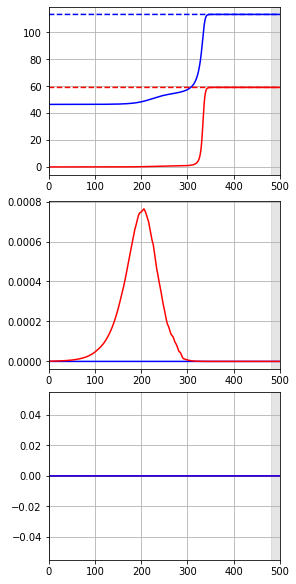

ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


-------  68 0.5750000000000002 0.6500000000000004
init ind =  1707
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  0.008056642285141465
RUN  0 , total integrated cost =  0.008056642285141465
Gradient descend method:  None
RUN  0 , total integrated cost =  0.008056642285141465
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.505842167846815 1.5058420637991183
Problem in initial value trasfer pre:  tau_exc 20.040519851084856 20.040520810290758
uncontrolled cost :  862467.9253654084
cost splitting :  4.522136897349114e-25 [0. 0.]


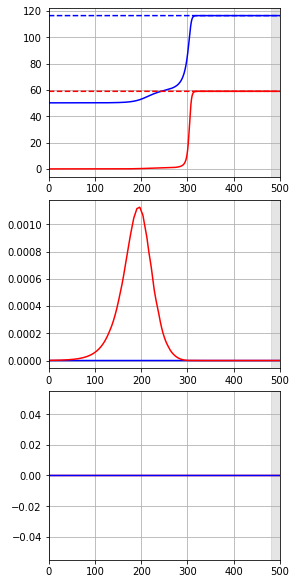

-------  71 0.47500000000000014 0.6750000000000004
init ind =  1707
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  384005.59692905797
RUN  0 , total integrated cost =  384005.59692905797
Gradient descend method:  None
RUN  0 , total integrated cost =  384005.59692905797
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
uncontrolled cost :  384005.59692905797
cost splitting :  384005.59692905797 [0. 0.]


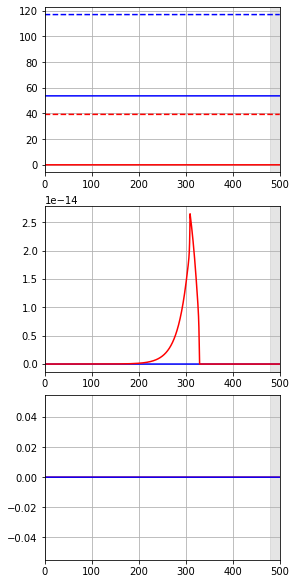

ERROR:root:Problem in initial value trasfer pre


-------  74 0.5500000000000003 0.6750000000000004
init ind =  1568
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  0.021223812262723768
RUN  0 , total integrated cost =  0.021223812262723768
Gradient descend method:  None
RUN  0 , total integrated cost =  0.021223812262723768
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
Problem in initial value trasfer pre:  tau_exc 21.010895883751388 21.010895925930843
uncontrolled cost :  732509.8149166821
cost splitting :  3.1403728453813175e-25 [0. 0.]


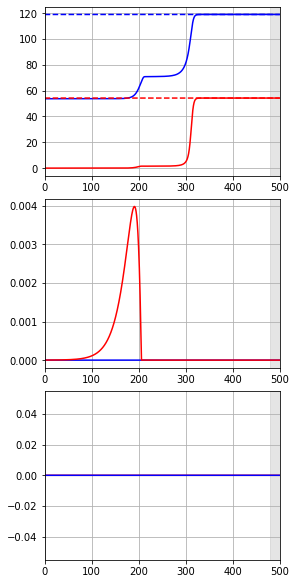

ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


-------  75 0.5750000000000002 0.6750000000000004
init ind =  1829
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  0.009943325940079534
RUN  0 , total integrated cost =  0.009943325940079534
Gradient descend method:  None
RUN  0 , total integrated cost =  0.009943325940079534
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5044676492249998 1.5044675848457336
Problem in initial value trasfer pre:  tau_exc 20.280406116717227 20.280406677285733
uncontrolled cost :  858276.8196420075
cost splitting :  2.0098386210440446e-25 [0. 0.]


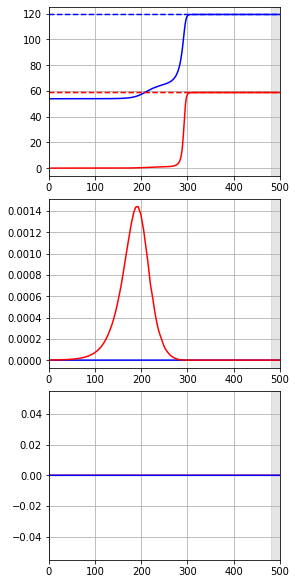

In [95]:
for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = dur
    max_it = int(0)
    limit = 1e-6
    
    if i in bad:
        continue
        
    for l in range( bestControl_[i].shape[2] ):
        if ( np.abs(bestControl_[i][0,2,l]) > limit or np.abs(bestControl_[i][0,3,l]) > limit
            or np.abs(bestControl_[i][0,4,l]) > limit or np.abs(bestControl_[i][0,5,l]) > limit ):
            init_ind = l - n_pre
            break
            
    if init_ind == -1:
        init_ind = 0
            
    print("init ind = ", init_ind)

    weight_ = 1.
    cost.setParams(1., weight_ * factor_we, weight_ * factor_ws)
    weights_[i] = cost.getParams()

    setinit(initVars[i], aln)

    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[i][0]
    target_[:,1,:] = target[i][1]

    control0 = aln.getZeroControl()
    if init_ind != 0:
        control0[:,:,:-init_ind] = bestControl_[i][:,:,n_pre-1+init_ind:-n_post+1]
    else:
        control0 = bestControl_[i][:,:,n_pre-1:-n_post+1]

    bestControl_[i], bestState_[i], cost_[i], runtime_, grad_, phi_, phi1_, costnode_[i] = aln.A1(
        control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
        prec_variables_ = p_var, transition_time_ = t_pen)

    print('uncontrolled cost : ', cost_uncontrolled[i])
    print('cost splitting : ', costnode_[i][0][0][0], costnode_[i][2][0][:2])

    if True:
        plot_time_array = np.arange(0.,round(dur+aln.params.dt,1),aln.params.dt)
        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        fig, ax = plt.subplots(3,1, constrained_layout=True, figsize = (4,8) )

        ax[0].plot(plot_time_array, bestState_[i][0,0,n_pre-1:-n_post+1], color= 'red')
        ax[0].plot(plot_time_array, bestState_[i][0,1,n_pre-1:-n_post+1], color= 'blue')
        ax[0].plot(plot_time_array, target_[0,0,n_pre-1:-n_post+1], linestyle = '--', color='red')
        ax[0].plot(plot_time_array, target_[0,1,n_pre-1:-n_post+1], linestyle = '--', color='blue')

        ax[1].plot(plot_time_array, bestControl_[i][0,3,n_pre-1:-n_post+1], color = 'blue')
        ax[1].plot(plot_time_array, bestControl_[i][0,2,n_pre-1:-n_post+1], color = 'red')

        ax[2].plot(plot_time_array, bestControl_[i][0,4,n_pre-1:-n_post+1], color = 'red')
        ax[2].plot(plot_time_array, bestControl_[i][0,5,n_pre-1:-n_post+1], color = 'blue')

        for k in range(3):
            ax[k].set_xlim(0.,dur)
            ax[k].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
        plt.show()

In [100]:
tol = 1. * 1e-11    # 6.
conv_shift = [None] * len(exc)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    if i in bad:
        continue
    
    aln.params.duration = dur
    max_it = int(1000)
    
    while not conv_shift[i]:
            
        weight_ = 1.
        cost.setParams(1., weight_ * factor_we, weight_ * factor_ws)
        weights_[i] = cost.getParams()

        setinit(initVars[i], aln)

        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        control0 = aln.getZeroControl()
        control0 = bestControl_[i][:,:,n_pre-1:-n_post+1]

        bestControl_[i], bestState_[i], cost_[i], runtime_, grad_, phi_, phi1_, costnode_[i]= aln.A1(
            control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
            prec_variables_ = p_var, transition_time_ = t_pen)
        
        if cost_[i][-1] == 0.:
            conv_shift[i] = True

        print('uncontrolled cost : ', cost_uncontrolled[i])
        print('cost splitting : ', costnode_[i][0][0][0], costnode_[i][2][0][2:6])

        if conv_shift[i] and False:
            plot_time_array = np.arange(0.,round(dur+aln.params.dt,1),aln.params.dt)
            target_ = aln.getZeroTarget()
            target_[:,0,:] = target[i][0]
            target_[:,1,:] = target[i][1]

            fig, ax = plt.subplots(3,1, constrained_layout=True, figsize = (4,8) )

            ax[0].plot(plot_time_array, bestState_[i][0,0,n_pre-1:-n_post+1], color= 'red')
            ax[0].plot(plot_time_array, bestState_[i][0,1,n_pre-1:-n_post+1], color= 'blue')
            ax[0].plot(plot_time_array, target_[0,0,n_pre-1:-n_post+1], linestyle = '--', color='red')
            ax[0].plot(plot_time_array, target_[0,1,n_pre-1:-n_post+1], linestyle = '--', color='blue')

            ax[1].plot(plot_time_array, bestControl_[i][0,3,n_pre-1:-n_post+1], color = 'blue')
            ax[1].plot(plot_time_array, bestControl_[i][0,2,n_pre-1:-n_post+1], color = 'red')

            ax[2].plot(plot_time_array, bestControl_[i][0,4,n_pre-1:-n_post+1], color = 'red')
            ax[2].plot(plot_time_array, bestControl_[i][0,5,n_pre-1:-n_post+1], color = 'blue')

            for k in range(3):
                ax[k].set_xlim(0.,dur)
                ax[k].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
            plt.show()
            
        with open(file_,'wb') as f:
            pickle.dump([bestControl_, bestState_, cost_, costnode_, weights_], f)
            

-------  40 0.5250000000000001 0.5500000000000003
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  0.01795359423053415
RUN  0 , total integrated cost =  0.01795359423053415
Gradient descend method:  None
RUN  1 , total integrated cost =  0.017953591673017064


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


Control only changes marginally.
RUN  1 , total integrated cost =  0.017953591673017064
Improved over  1  iterations in  0.19416805999935605  seconds by  1.4245153664660393e-05  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5104344949752526 1.5104344770085656
Problem in initial value trasfer pre:  tau_exc 20.72012142522508 20.720121560964863
uncontrolled cost :  635238.4079859259
cost splitting :  2.9951871279936386e-23 [0.01795359 0.         0.         0.        ]
-------  46 0.5250000000000001 0.5750000000000003
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  0.02164062958842847
RUN  0 , total integrated cost =  0.02164062958842847
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  0.02164062632879944
Control only changes marginally.
RUN  1 , total integrated cost =  0.02164062632879944
Improved over  1  iterations in  0.1957286609977018  seconds by  1.5062542516375288e-05  percent.
Problem in initial value trasfer pre:  tau_exc 20.968375036952285 20.96837508523426
uncontrolled cost :  629845.1306750294
cost splitting :  3.138739851501721e-24 [0.02164063 0.         0.         0.        ]
-------  47 0.5500000000000003 0.5750000000000003
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  0.01081441459811289
RUN  0 , total integrated cost =  0.01081441459811289
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  0.010814411984156164
Control only changes marginally.
RUN  1 , total integrated cost =  0.010814411984156164
Improved over  1  iterations in  0.28577017900533974  seconds by  2.417104228413791e-05  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5089984866711772 1.5089984167235608
Problem in initial value trasfer pre:  tau_exc 20.22212870481313 20.22212931687628
uncontrolled cost :  751175.9333805718
cost splitting :  2.41626689764668e-15 [0.01081441 0.         0.         0.        ]
-------  53 0.5500000000000003 0.6000000000000003
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  0.013748300655738909
RUN  0 , total integrated cost =  0.013748300655738909
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  0.013748292273839672
Control only changes marginally.
RUN  1 , total integrated cost =  0.013748292273839672
Improved over  1  iterations in  0.20105380000313744  seconds by  6.096680198197646e-05  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5067436824094098 1.506743648721407
Problem in initial value trasfer pre:  tau_exc 20.53175493676201 20.531755210092612
uncontrolled cost :  746144.5805987157
cost splitting :  4.522136897349114e-25 [0.01374829 0.         0.         0.        ]
-------  61 0.5750000000000002 0.6250000000000003
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  0.005781597043504586
RUN  0 , total integrated cost =  0.005781597043504586
Gradient descend method:  None
RUN  1 , total integrated cost =  0.005781596990859812
RUN  2 , total integrated cost =  0.005781596988476312
RUN  3 , total integrated cost =  0.005781596982210347


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  4 , total integrated cost =  0.005781596982210347
Control only changes marginally.
RUN  4 , total integrated cost =  0.005781596982210347
Improved over  4  iterations in  1.2289294919974054  seconds by  1.060161025634443e-06  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5080478142378089 1.508047635408733
Problem in initial value trasfer pre:  tau_exc 19.698150393027262 19.69815215473625
uncontrolled cost :  866710.8536802017
cost splitting :  2.8666247254017104e-09 [0.00578159 0.         0.         0.        ]
-------  68 0.5750000000000002 0.6500000000000004
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  0.007999705047717779
RUN  0 , total integrated cost =  0.007999705047717779
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  0.007999703789698467
Control only changes marginally.
RUN  1 , total integrated cost =  0.007999703789698467
Improved over  1  iterations in  0.33289235000120243  seconds by  1.572582119990784e-05  percent.
Problem in initial value trasfer pre:  sigmae_f 1.505842167846815 1.5058420645344233
Problem in initial value trasfer pre:  tau_exc 20.040519851084856 20.04052080351205
uncontrolled cost :  862467.9253654084
cost splitting :  9.949800235334377e-11 [0.0079997 0.        0.        0.       ]
-------  71 0.47500000000000014 0.6750000000000004
-------  74 0.5500000000000003 0.6750000000000004
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  0.02122283437402044
RUN  0 , total integrated cost =  0.02122283437402044
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  0.02122283332628362
Control only changes marginally.
RUN  1 , total integrated cost =  0.02122283332628362
Improved over  1  iterations in  0.21480281399999512  seconds by  4.936837356694923e-06  percent.
Problem in initial value trasfer pre:  tau_exc 21.010895883751388 21.0108959259289
uncontrolled cost :  732509.8149166821
cost splitting :  3.1403728453813175e-25 [0.02122283 0.         0.         0.        ]
-------  75 0.5750000000000002 0.6750000000000004
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
initial cost =  0.009880741063090216
RUN  0 , total integrated cost =  0.009880741063090216
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  0.009880735477482742
Control only changes marginally.
RUN  1 , total integrated cost =  0.009880735477482742
Improved over  1  iterations in  0.2844008589963778  seconds by  5.6530248457420385e-05  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5044676492249998 1.5044675852509637
Problem in initial value trasfer pre:  tau_exc 20.280406116717227 20.280406673757277
uncontrolled cost :  858276.8196420075
cost splitting :  2.4860030086376115e-14 [0.00988074 0.         0.         0.        ]


-------  40 0.5250000000000001 0.5500000000000003


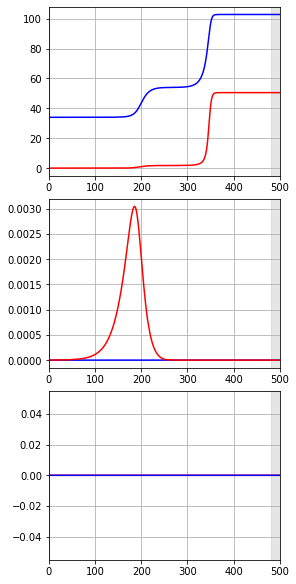

-------  46 0.5250000000000001 0.5750000000000003


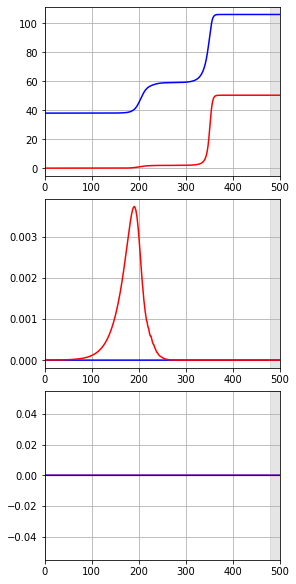

-------  47 0.5500000000000003 0.5750000000000003


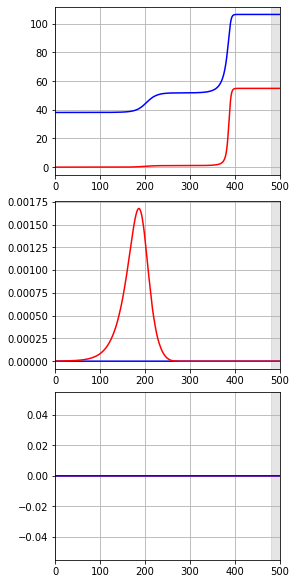

-------  53 0.5500000000000003 0.6000000000000003


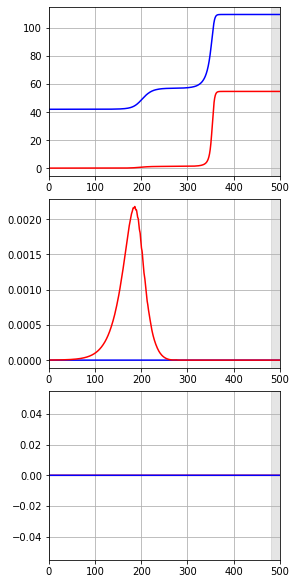

-------  61 0.5750000000000002 0.6250000000000003


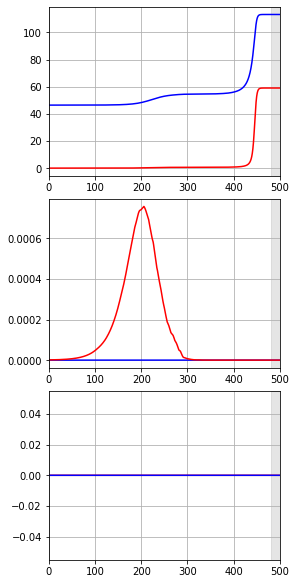

-------  68 0.5750000000000002 0.6500000000000004


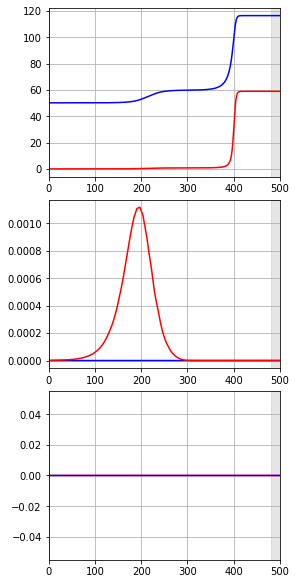

-------  71 0.47500000000000014 0.6750000000000004
-------  74 0.5500000000000003 0.6750000000000004


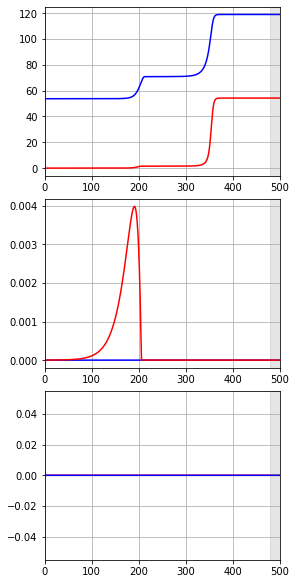

-------  75 0.5750000000000002 0.6750000000000004


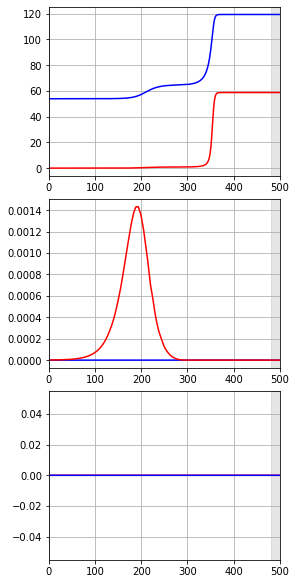

In [98]:
for i in i_range:
    print("------- ", i, exc[i], inh[i])
    
    if i in bad:
        bestControl_[i] = None
        continue
        
    plot_time_array = np.arange(0.,round(dur+aln.params.dt,1),aln.params.dt)


    fig, ax = plt.subplots(3,1, constrained_layout=True, figsize = (4,8) )

    ax[0].plot(plot_time_array, bestState_[i][0,0,n_pre-1:-n_post+1], color= 'red')
    ax[0].plot(plot_time_array, bestState_[i][0,1,n_pre-1:-n_post+1], color= 'blue')

    ax[1].plot(plot_time_array, bestControl_[i][0,3,n_pre-1:-n_post+1], color = 'blue')
    ax[1].plot(plot_time_array, bestControl_[i][0,2,n_pre-1:-n_post+1], color = 'red')

    ax[2].plot(plot_time_array, bestControl_[i][0,4,n_pre-1:-n_post+1], color = 'red')
    ax[2].plot(plot_time_array, bestControl_[i][0,5,n_pre-1:-n_post+1], color = 'blue')

    for k in range(3):
        ax[k].set_xlim(0.,dur)
        ax[k].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
    plt.show()


In [43]:
for i in range(len(bestControl_)):
    if type(bestControl_[i]) != type(None):
        print(i)

0
1
2
3
4
5
12
24
36
48
60
72
